In [1]:
%load_ext pycodestyle_magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

pd.options.display.max_columns = None

In [2]:
data = pd.read_csv('data_nettoyee.csv')
print(f'Le fichier data_nettoyee contient {data.shape[0]} lignes et {data.shape[1]} colonnes')

Le fichier data_nettoyee contient 115608 lignes et 40 colonnes


### Correction des types

In [3]:
liste_date = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date',
              'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date']

for date in liste_date:
    data[date]=data[date].astype('datetime64[ns]')

## Ajout des variables

In [4]:
# Recency
max_date = max(data['order_purchase_timestamp'])
data['dernier_achat_jours'] = (max_date - data['order_purchase_timestamp']).dt.days

recency = data.groupby('customer_unique_id')['dernier_achat_jours'].min()  #.min afin d'avoir la date la plus récente par customer_unique_id
recency = recency.reset_index()
recency.columns = ['customer_unique_id', 'recency']

In [5]:
# monetary - correspond à la somme des achats par client
data['prix_total'] = data['price'] + data['freight_value']

monetary = data.groupby('customer_unique_id')['prix_total'].sum()
monetary = monetary.reset_index()
monetary.columns = ['customer_unique_id', 'monetary']

In [6]:
# Frequency - correspond au nombre d'achats réalisé par client
frequency = data.groupby('customer_unique_id')['order_id'].count()
frequency = frequency.reset_index()
frequency.columns = ['customer_unique_id', 'frequency']

In [7]:
# Review_score_mean - correspond au score moyen par commande
Review_score_mean = data.groupby(['customer_unique_id','order_id']).agg({"review_score": 'mean'})
Review_score_mean.columns = ['review_score_mean']
Review_score_mean = Review_score_mean.groupby(['customer_unique_id'])['review_score_mean'].mean()
Review_score_mean = Review_score_mean.reset_index()

In [8]:
# Nb_payment_type - correspond au nombre de type de paiements différents utilisés par un client
Nb_payment_type = data.groupby(['customer_unique_id']).agg({'payment_type': lambda x: x.nunique()})
Nb_payment_type.columns = ['Nb_payment_type']
Nb_payment_type = Nb_payment_type.reset_index()

In [9]:
# Création d'un df avec la dernière date d'achat du client
data['order_purchase_last_timestamp'] = data.groupby('customer_unique_id')['order_purchase_timestamp'].transform(lambda x: x.max())
data_unique = data[['customer_unique_id', 'order_purchase_last_timestamp']]
data_unique.drop_duplicates(subset='customer_unique_id', inplace=True)

/tmp/ipykernel_13549/3146655881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique.drop_duplicates(subset='customer_unique_id', inplace=True)


In [10]:
# Regroupement des données dans un df unique
df_global = pd.merge(recency, frequency, on='customer_unique_id')
df_global = pd.merge(df_global, monetary, on='customer_unique_id')
df_global = pd.merge(df_global, Review_score_mean, on='customer_unique_id')
df_global = pd.merge(df_global, Nb_payment_type, on='customer_unique_id')
df_global = pd.merge(df_global, data_unique, on='customer_unique_id')
df_global.shape

(93395, 7)

In [11]:
# Transformation de la date en plusieurs colonnes
df_global['year_month_day'] = df_global['order_purchase_last_timestamp'].dt.to_period('D')
df_global['year'] = df_global['order_purchase_last_timestamp'].dt.year
df_global['week'] = df_global['order_purchase_last_timestamp'].dt.week
df_global['year-week'] = df_global['order_purchase_last_timestamp'].dt.strftime('%Y-%U')
df_global.drop(['order_purchase_last_timestamp'], axis=1, inplace=True)
df_global.shape

/tmp/ipykernel_13549/1823028352.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_global['week'] = df_global['order_purchase_last_timestamp'].dt.week


(93395, 10)

### Traitement des outliers

In [12]:
# Suppression outliers avec la méthode des quantiles
def traitement_outlier_quantile(df, Q1_limite, Q3_limite):

    # monetary
    Q1 = df.monetary.quantile(Q1_limite)
    Q3 = df.monetary.quantile(Q3_limite)
    IQR = Q3 - Q1
    df = df[(df.monetary >= Q1 - 1.5*IQR) & (df.monetary <= Q3 + 1.5*IQR)]

    # frequency
    Q1 = df.frequency.quantile(Q1_limite)
    Q3 = df.frequency.quantile(Q3_limite)
    IQR = Q3 - Q1
    df = df[(df.frequency >= Q1 - 1.5*IQR) & (df.frequency <= Q3 + 1.5*IQR)]

    # recency
    Q1 = df.recency.quantile(Q1_limite)
    Q3 = df.recency.quantile(Q3_limite)
    IQR = Q3 - Q1
    df = df[(df.recency >= Q1 - 1.5*IQR) & (df.recency <= Q3 + 1.5*IQR)]

    df.reset_index()
    display(df.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
    return df


In [13]:
# Traitement des outliers
df_global = traitement_outlier_quantile(df_global, 0.01, 0.99)
df_global.set_index('customer_unique_id', inplace=True)
print(df_global.shape)

,recency,frequency,monetary,review_score_mean,Nb_payment_type,year,week
count,93191.000000,93191.000000,93191.000000,93191.000000,93191.000000,93191.000000,93191.000000
mean,241.702053,1.219345,168.848508,4.105607,1.025582,2017.549635,24.367654
std,153.126302,0.647839,211.395671,1.323753,0.158631,0.503770,13.992832
min,0.000000,1.000000,10.070000,1.000000,1.000000,2016.000000,1.000000
1%,13.000000,1.000000,22.840000,1.000000,1.000000,2017.000000,1.000000
5%,27.000000,1.000000,32.790000,1.000000,1.000000,2017.000000,3.000000
10%,45.000000,1.000000,40.680000,1.000000,1.000000,2017.000000,6.000000
25%,118.000000,1.000000,64.000000,4.000000,1.000000,2017.000000,13.000000
50%,222.000000,1.000000,110.090000,5.000000,1.000000,2018.000000,24.000000
75%,351.000000,1.000000,188.385000,5.000000,1.000000,2018.000000,34.000000


(93191, 9)


## Test 1 - 6 features // n_clusters = 6

Création des dataframes pour le calcul de l'ARI

In [14]:
Liste_features = ['recency', 'frequency', 'monetary', 'review_score_mean', 'Nb_payment_type']

In [15]:
# Création du df de référence
df_initial = df_global[df_global['year'] == 2017][Liste_features]
initial_index = df_initial.index

In [16]:
# Définition des dataframes par plage temporelle
dfs_W = []

for i in range(0, 35):
    dfs_W.append(pd.DataFrame())

dfs_W[0] = df_global[df_global['year'] == 2017][Liste_features]

for i in range(1, 10):
    dfs_W[i] = pd.concat([df_global[(df_global['year-week'] == '2018-0%s' % i)][Liste_features], dfs_W[i-1]])
    print(dfs_W[i].shape)

for i in range(10, 35):
    dfs_W[i] = pd.concat([df_global[(df_global['year-week'] == '2018-%s' % i)][Liste_features], dfs_W[i-1]])
    print(dfs_W[i].shape)

(43027, 5)
(44672, 5)
(46177, 5)
(47638, 5)
(49142, 5)
(50626, 5)
(52225, 5)
(53993, 5)
(55547, 5)
(57066, 5)
(58724, 5)
(60099, 5)
(61641, 5)
(63071, 5)
(64707, 5)
(66352, 5)
(68012, 5)
(69934, 5)
(71758, 5)
(72740, 5)
(73704, 5)
(75093, 5)
(76618, 5)
(77996, 5)
(79399, 5)
(80609, 5)
(81537, 5)
(83093, 5)
(84709, 5)
(86624, 5)
(88637, 5)
(90451, 5)
(91629, 5)
(91814, 5)


In [17]:
# Définition du modèle initial
m_initial = make_pipeline(StandardScaler(), KMeans(n_clusters=6, init = 'k-means++', random_state= 0)).fit(df_initial)

# Prédiction sur le jeu de 2017 : référence
labels_true_initial=m_initial.predict(df_initial)

In [18]:
# Réalisation des prédictions pour l'ensemble des périodes avec le modèle intial
for i in range(0, 35):
    dfs_W[i]['pred'] = m_initial.fit_predict(dfs_W[i])

In [19]:
# Filtre sur les clients initiaux
label_pred = []
for i in range(0, 35):
    label_pred.append(dfs_W[i][dfs_W[i].index.isin(initial_index)]['pred'])

### Calcul ARI

In [20]:
ari=[]

# Score ARI initial = 1 
ari.append(adjusted_rand_score(labels_true_initial, labels_true_initial))
    
for i in range(1, 35):
    ari.append(adjusted_rand_score(labels_true_initial, label_pred[i]))

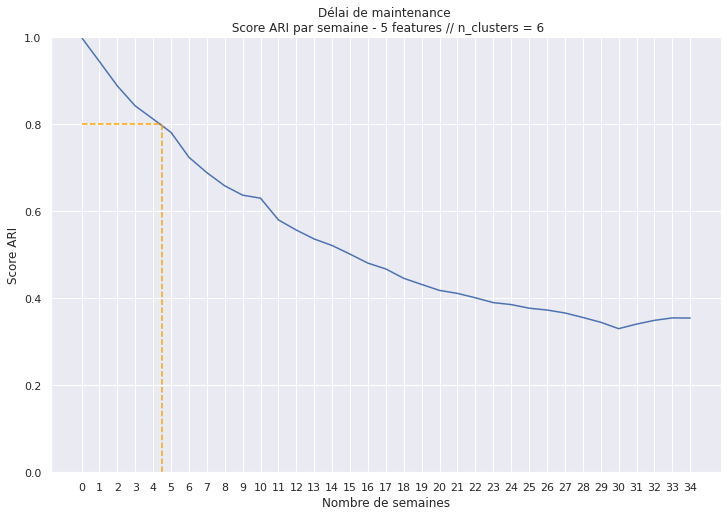

In [21]:
# Visualisation du score ARI
sns.set()
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x=range(0, 35, 1), y=ari)

_ = ax.set_title('Délai de maintenance \n Score ARI par semaine - 5 features // n_clusters = 6')
_ = ax.set_ylabel('Score ARI')
_ = ax.set_xlabel('Nombre de semaines')
_ = ax.xaxis.set_ticks(range(0, 35, 1))
ax.set_ylim(0, 1)

plt.plot([0, 4.5], [0.8, 0.8], color='orange', linestyle='dashed')  # [x1,x2],[y1,y2]
plt.axvline(x=4.5, ymax=0.8, color='orange', linestyle='dashed')

### Test avec un dataframe RFM // 4 clusters

In [22]:
Liste_features_2 = ['recency','frequency','monetary']

In [23]:
# Définition des dataframes par plage temporelle
dfs2_W = []

for i in range(0, 35):
    dfs2_W.append(pd.DataFrame())

dfs2_W[0] = df_global[df_global['year'] == 2017][Liste_features_2]
initial_index_2 = dfs2_W[0].index

for i in range(1, 10):
    dfs2_W[i] = pd.concat([df_global[(df_global['year-week'] == '2018-0%s' %i)][Liste_features_2], dfs2_W[i-1]])
    print(dfs2_W[i].shape)

for i in range(10, 35):
    dfs2_W[i] = pd.concat([df_global[(df_global['year-week'] == '2018-%s' %i)][Liste_features_2], dfs2_W[i-1]])
    print(dfs2_W[i].shape)

(43027, 3)
(44672, 3)
(46177, 3)
(47638, 3)
(49142, 3)
(50626, 3)
(52225, 3)
(53993, 3)
(55547, 3)
(57066, 3)
(58724, 3)
(60099, 3)
(61641, 3)
(63071, 3)
(64707, 3)
(66352, 3)
(68012, 3)
(69934, 3)
(71758, 3)
(72740, 3)
(73704, 3)
(75093, 3)
(76618, 3)
(77996, 3)
(79399, 3)
(80609, 3)
(81537, 3)
(83093, 3)
(84709, 3)
(86624, 3)
(88637, 3)
(90451, 3)
(91629, 3)
(91814, 3)


In [24]:
# Définition du modèle initial
m2_initial = make_pipeline(StandardScaler(), KMeans(n_clusters=4, init = 'k-means++', random_state= 0)).fit(dfs2_W[0])

# Prédiction sur le jeu de 2017 : référence
labels_true_2_initial=m2_initial.predict(dfs2_W[0])

In [25]:
# Réalisation des prédictions pour l'ensemble des périodes avec le modèle intial
for i in range(0, 35):
    dfs2_W[i]['pred'] = m2_initial.fit_predict(dfs2_W[i])

In [26]:
# Filtre sur les clients initiaux
label_2_pred = []
for i in range(0, 35):
    label_2_pred.append(dfs2_W[i][dfs2_W[i].index.isin(initial_index_2)]['pred'])    

### Calcul ARI

In [27]:
ari_2 = []

# Score ARI initial = 1 
ari_2.append(adjusted_rand_score(labels_true_2_initial, labels_true_2_initial))
    
for i in range(1, 35):
    ari_2.append(adjusted_rand_score(labels_true_2_initial, label_2_pred[i]))

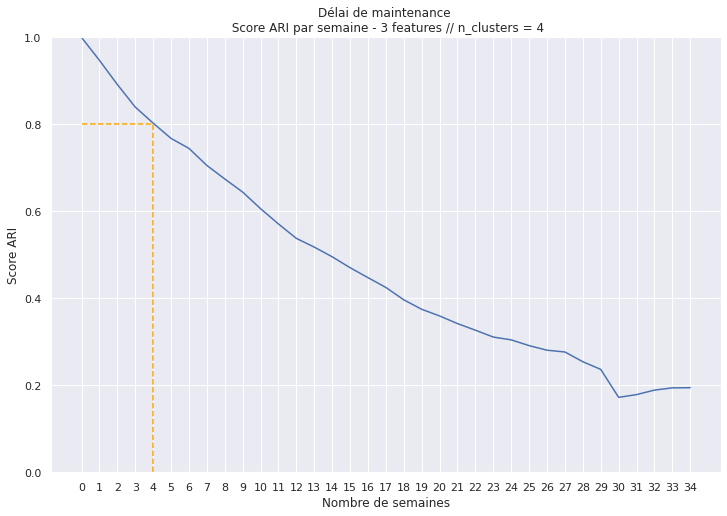

In [28]:
# Visualisation du score ARI
sns.set()
plt.figure(figsize=(12, 8))

ax = sns.lineplot(x=range(0, 35, 1), y=ari_2)
_ = ax.set_title('Délai de maintenance \n Score ARI par semaine - 3 features // n_clusters = 4')
_ = ax.set_ylabel('Score ARI')
_ = ax.set_xlabel('Nombre de semaines')
_ = ax.xaxis.set_ticks(range(0, 35, 1))
ax.set_ylim(0, 1)

plt.plot([0, 4], [0.8, 0.8], color='orange', linestyle='dashed')
plt.axvline(x=4, ymax=0.8, color='orange', linestyle='dashed')